In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, recall_score

from sklearn.linear_model import LinearRegression

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [2]:
import matplotlib
matplotlib.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

In [19]:
plt.rc('font', family='NanumGothicOTF')

In [3]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [4]:
### 데이터 불러오기 ###
df = pd.read_csv('Data/교통사망사고정보/original_kor.csv',encoding='CP949')
#df.drop(['temp1','temp2','temp3','발생분변환'],axis=1,inplace=True)

# 충남 연기군 -> 세종 세종 변경 (12년 7월)
df.loc[df.발생지시군구=='연기군','발생지시군구']='세종'
df.loc[(df.발생지시도=='충남')&(df.발생지시군구=='세종'),'발생지시도']='세종'

# 충북 청원군 -> 충북 청주시 변경 (14년 7월)
df.loc[df.발생지시군구=='청원군','발생지시군구']='청주시'

# 총부상자수 변수
df['총부상자수']=df.사상자수 - df.사망자수

# 사고피해정도 변수
df['사고피해정도']= df.부상신고자수 + (2 * df.경상자수) + (3 * df.중상자수) + (4 * df.사망자수)

# 사고위험도

경기도지역 통계자료에 보면, 교통사고 위험도라는 지표가 존재합니다.     
             
각 지역별로 다음을 계산.         
(사망자수*12 + 부상자수*3)/교통사고건수            
       
사망자수에 가중치를 더 주고 교통사고 건수로 나눴기때문에, 각 지역별로 교통사고가 발생했을 때 인명피해가 어느정도 나는지를 비교할 수 있을 것이라고 생각했습니다.
         
그런데 다른 지역에서는 이 지표에 관한 자료를 찾기 힘들어서, 구하는 식을 조금 변형해서 train data에 사용해보기로 했습니다.    
원래 지표의 분모에는 교통사고건수가 들어가는데, train data에서는 전체 교통사고 건수가 아닌 교통사망사고 건수를 구할 수 있으니, 분모를 교통사망사고건수로 넣고 계산해보기로 했습니다.     
            
이때 단순 지역별 사고 위험도만 계산하지 말고 train data에서 주어진 여러 변수들의 조합과 관련된 사고 위험도들을 계산하여, 사고 위험도가 높은 여러 조건들을 만들어 보고자 합니다.
예를들어, 요일x주야 별로 사고위험도1을 측정, 당사자종별 조합별로 사고위험도2를 측정한 결과, 토요일 낮에 발생하는 사고들이 사고위험도1이 높고, 승합차-승합차 조합에서 사고위험도2가 높게 나타났다고 하면, 어떤 교통사고가 토요일 낮에 승합차 승합차끼리 발생했으면, 사고위험도 합이 매우 높으니 대형 교통사고일 확률이 조금 높지 않을까 생각했습니다.     

그런데 사고 피해자들 수치를 이용해서 위험도라는 변수를 새로 만드니까, 이 변수를 이용해서 다시 피해자들 수치를 예측하면 답을 알고 수치를 예측하는 것과 같아서 train set안에서 overfitting 될 가능성이 높다고 생각한다. 이에 애초에 train set을 train_train, train_test set으로 나눈 후, train_train set 데이터만 이용해서 이 위험도를 측정한 후, 이를 train_test set에도 적용시켜서 위험도가 높은 사고일수록 실제 피해가 크게 나타나는지를 확인해보고자 함.  

In [5]:
df.columns

Index(['발생년', '발생년월일시', '발생분', '주야', '요일', '사망자수', '사상자수', '중상자수', '경상자수',
       '부상신고자수', '발생지시도', '발생지시군구', '사고유형_대분류', '사고유형_중분류', '사고유형', '법규위반_대분류',
       '법규위반', '도로형태_대분류', '도로형태', '당사자종별_1당_대분류', '당사자종별_1당', '당사자종별_2당_대분류',
       '당사자종별_2당', '발생위치X_UTMK', '발생위치Y_UTMK', '경도', '위도', '총부상자수', '사고피해정도'],
      dtype='object')

In [6]:
X = df[['주야', '요일','사망자수', '사상자수', '중상자수', '경상자수', '부상신고자수','총부상자수', '발생지시도', '발생지시군구', '사고유형_대분류', '사고유형_중분류', '법규위반', '도로형태_대분류', '도로형태', '당사자종별_1당_대분류',
       '당사자종별_2당_대분류']]

y = df[['사망자수', '사상자수', '중상자수', '경상자수', '부상신고자수']]

In [7]:
train_train, train_test, y_train, y_test = train_test_split(X,y,test_size=0.4, random_state=42)

In [8]:
train_train.shape, y_train.shape, train_test.shape, y_test.shape

((15022, 17), (15022, 5), (10015, 17), (10015, 5))

## 1. 발생시군구_위험도

In [9]:
df_big = df[(df.사망자수>=3)|(df.사상자수>=20)]

In [10]:
df_big.groupby(['발생지시도','발생지시군구']).count().발생년.sort_values(ascending=False).head()

발생지시도  발생지시군구
경기     화성시       5
인천     서구        5
전남     여수시       5
충남     천안시       4
충북     충주시       4
Name: 발생년, dtype: int64

사망자수가 3명 이상이거나, 사상자수가 20명 이상인 사고를 대형교통사고라고 한다.     
대형교통사고는 애초에 잘 발생하지 않아서 아예 발생하지 않은 지역도 있는데, 반대로 특히 몇몇 지역에서는 4~5번씩 자주 발생했음.    
교통사고가 발생하면 대형교통사고로 이어지기 쉬운 특정 지역이 있을 것이라고 생각.        
                           
이때 시도 단위는 너무 넓어서 그런 특정 일부 지역의 특성을 반영하지는 못한다고 생각해서 군구 단위로 위험도를 계산해보기로 함. 

In [11]:
# 지역별 전체 교통사고 횟수

total= train_train.groupby(['발생지시도','발생지시군구']).count().주야.sort_index()
#total

# 지역별 사망자 수

a = train_train.groupby(['발생지시도','발생지시군구']).sum().사망자수.sort_index()
#a

# 지역별 총 부상자수

b = train_train.groupby(['발생지시도','발생지시군구']).sum().총부상자수.sort_index()
#b

temp = (a*12 + b*3)/total

for i,j in temp.index:
    train_train.loc[(train_train.발생지시도==i)&(train_train.발생지시군구==j),'발생시군구_위험도'] = temp[i,j]

train_train.발생시군구_위험도.describe()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


count    15022.000000
mean        14.273865
std          1.070885
min         12.000000
25%         13.688702
50%         14.178082
75%         14.742188
max         26.666667
Name: 발생시군구_위험도, dtype: float64

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


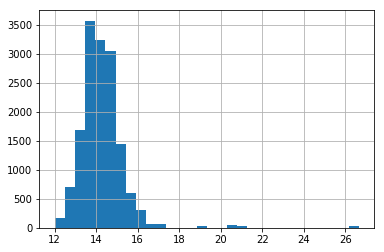

In [12]:
train_train.발생시군구_위험도.hist(bins=30);

대부분의 시군구지역의 위험도는 15안쪽이고, 높은 지역은 26까지도 나타남.       
개인적으로는 16을 기준으로 16이상인 지역은 위험도가 높은지역, 미만인 지역은 위험도가 낮은 지역으로 볼 수 있지 않을까 생각. 

In [13]:
train_train[train_train.발생시군구_위험도>=16].groupby('발생지시군구').mean().발생시군구_위험도.sort_values(ascending=False)

발생지시군구
고성군     26.666667
곡성군     20.806452
평창군     20.341463
단양군     19.200000
임실군     17.333333
중구      17.225806
부평구     16.615385
인제군     16.500000
해운대구    16.260000
보령시     16.237500
장수군     16.050000
Name: 발생시군구_위험도, dtype: float64

위험도가 높은 지역 몇몇을 확인해보면, 고성군, 곡성군, 평창군, 단양군과 같이 주로 지방쪽 지역의 사고 위험도가 높게 나타나는 것 같다.

In [14]:
# train data에서 구한 시군구별 위험도를 test data에 적용

temp = train_train.groupby(['발생지시도','발생지시군구']).mean().발생시군구_위험도

for i, j in temp.index:
    train_test.loc[(train_test.발생지시도==i)&(train_test.발생지시군구==j),'발생시군구_위험도'] = temp[i,j]    

#train_test.발생시군구_위험도.describe()

이 위험도가 test data에 의미있게 작용하는지를 어떻게 확인할 수 있을지 고민해봄.    
사망자수나 중상자수, 경상자수같은 수치는 애초에 수치의 range가 너무 작으니, 수치의 range가 큰 사상자수를 이용해서 확인해보기로 함.     
                      
test data에서 사상자수가 높은 data일수록 위험도 수치가 높다고 나타난 data의 비율이 높으면, 어느정도 쓸만한 변수라고 생각

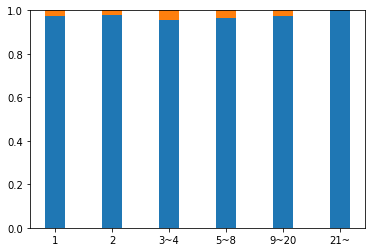

In [15]:
high=[]
low=[]

# 사상자수 1
total = train_test[(train_test.사상자수==1)].shape[0]
a = train_test[(train_test.사상자수==1)&(train_test.발생시군구_위험도<=16)].shape[0]
b = train_test[(train_test.사상자수==1)&(train_test.발생시군구_위험도>16)].shape[0]

low.append(a/total)
high.append(b/total)

# 사상자수 2
total = train_test[(train_test.사상자수==2)].shape[0]
a = train_test[(train_test.사상자수==2)&(train_test.발생시군구_위험도<=16)].shape[0]
b = train_test[(train_test.사상자수==2)&(train_test.발생시군구_위험도>16)].shape[0]

low.append(a/total)
high.append(b/total)

# 사상자수 3~4
total = train_test[(train_test.사상자수>=3)&(train_test.사상자수<=4)].shape[0]
a = train_test[(train_test.사상자수>=3)&(train_test.사상자수<=4)&(train_test.발생시군구_위험도<=16)].shape[0]
b = train_test[(train_test.사상자수>=3)&(train_test.사상자수<=4)&(train_test.발생시군구_위험도>16)].shape[0]

low.append(a/total)
high.append(b/total)

# 사상자수 5~8
total = train_test[(train_test.사상자수>=5)&(train_test.사상자수<=8)].shape[0]
a = train_test[(train_test.사상자수>=5)&(train_test.사상자수<=8)&(train_test.발생시군구_위험도<=16)].shape[0]
b = train_test[(train_test.사상자수>=5)&(train_test.사상자수<=8)&(train_test.발생시군구_위험도>16)].shape[0]

low.append(a/total)
high.append(b/total)

# 사상자수 9~20
total = train_test[(train_test.사상자수>=9)&(train_test.사상자수<=20)].shape[0]
a = train_test[(train_test.사상자수>=9)&(train_test.사상자수<=20)&(train_test.발생시군구_위험도<=16)].shape[0]
b = train_test[(train_test.사상자수>=9)&(train_test.사상자수<=20)&(train_test.발생시군구_위험도>16)].shape[0]

low.append(a/total)
high.append(b/total)

# 사상자수 20~
total = train_test[(train_test.사상자수>=21)].shape[0]
a = train_test[(train_test.사상자수>=21)&(train_test.발생시군구_위험도<=16)].shape[0]
b = train_test[(train_test.사상자수>=21)&(train_test.발생시군구_위험도>16)].shape[0]

low.append(a/total)
high.append(b/total)

N = 6 
ind = np.arange(N)
width = 0.35

p1 = plt.bar(ind, low, width)
p2 = plt.bar(ind, high, width, bottom=low)

#plt.ylabel('주야 비율')
plt.xticks(ind, ('1','2','3~4','5~8','9~20','21~'))
#plt.legend((p1[0],p2[0]),('주간','야간'))
plt.show()

사상자수가 많아지더라도 위험도 수치가 높다고 나타난 변수 비율에 큰 차이가 없어서 단순히 이 변수 하나만으로는 의미가 없다고 생각. 하지만 다른 위험도 변수들과 같이 위험도 합이나 가중평균에 같이 사용됐을 때 의미가 있을 수 도 있다고 생각.

## 2. 발생지시도x요일x주야 위험도

In [16]:
df['요일x주야'] = df['요일'] + '/' + df['주야']
temp = pd.DataFrame(df.groupby('요일x주야').mean().사상자수)
temp = temp.loc[['월/주간','월/야간','화/주간','화/야간','수/주간','수/야간','목/주간','목/야간','금/주간','금/야간','토/주간','토/야간','일/주간','일/야간']]
temp

,사상자수
요일x주야,
월/주간,1.612423
월/야간,1.487254
화/주간,1.681167
화/야간,1.481784
수/주간,1.659977
수/야간,1.567232
목/주간,1.682149
목/야간,1.466220
금/주간,1.780542


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['NanumGothicOTF'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


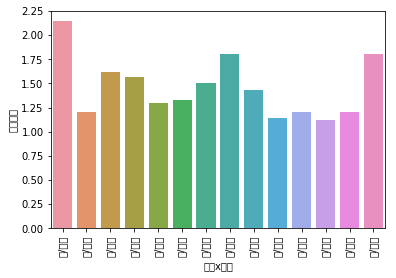

In [20]:
sns.barplot(x=temp.index, y=temp.사상자수)
plt.xticks(rotation='vertical');

보통 주간이 야간에비해 평균사상자수가 높게 나타난다. 또한 미세하긴 하지만 평일보다는 금토일 주간에 수치가 높게 나타난다.      
이는 주로 야간보다 주간에, 또 평일보다는 주말에 많이 활동하는 우리의 생활패턴이 반영된 결과라고 생각.     
       
요일과 주야와 더불어서 우리의 생활 패턴에 또 많은 영향을 주는 것은 어느 시도인지 라고 생각. 대도시인지 대도시 주변 지역인지에 따라서 요일,주야별로 사람들의 이동 패턴이 다르게 나타날 것임. 즉 차량의 흐름이 시도x요일x주야 별로 다르니, 평균 사상자수도 다른 패턴을 보일 것임.    
      
시도x요일x주야별로 평균 사상자수 살펴보기

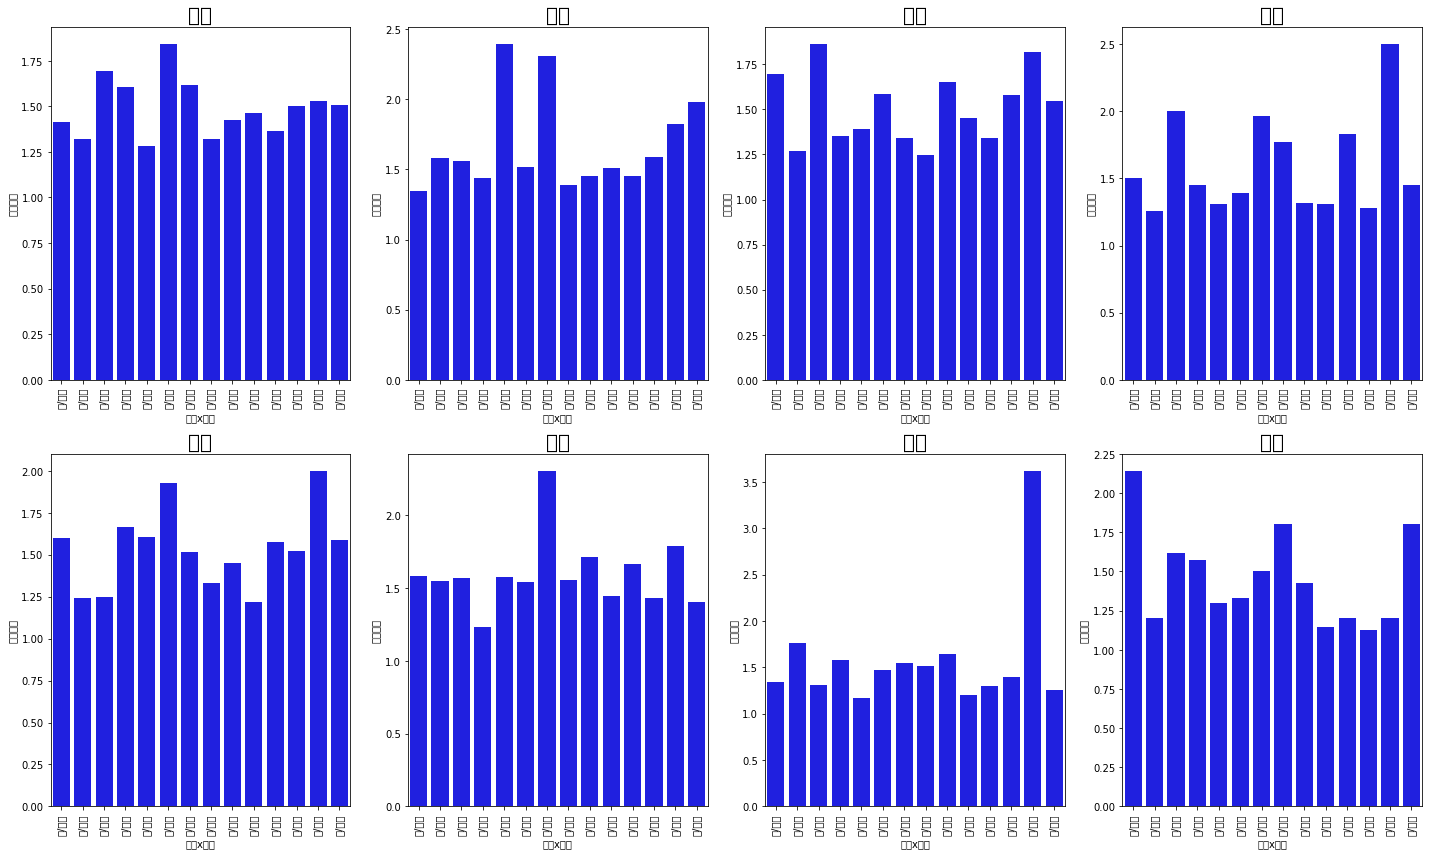

In [21]:
# 주요 도시별 시도x요일x주야 평균 사상자수

a = ['서울','인천','부산','울산','대구','광주','대전','세종']


fig = plt.figure(figsize=(20,12))

for n,i in enumerate(a):
    temp = pd.DataFrame(df[df.발생지시도==i].groupby('요일x주야').mean().사상자수)
    temp = temp.loc[['월/주간','월/야간','화/주간','화/야간','수/주간','수/야간','목/주간','목/야간','금/주간','금/야간','토/주간','토/야간','일/주간','일/야간']]
    
    
    
    ax = fig.add_subplot(2,4,n+1)
    sns.barplot(x=temp.index, y=temp.사상자수,ax=ax, color='b')
    plt.xticks(rotation='vertical')
    plt.title(i,fontsize=20)
    
plt.tight_layout()

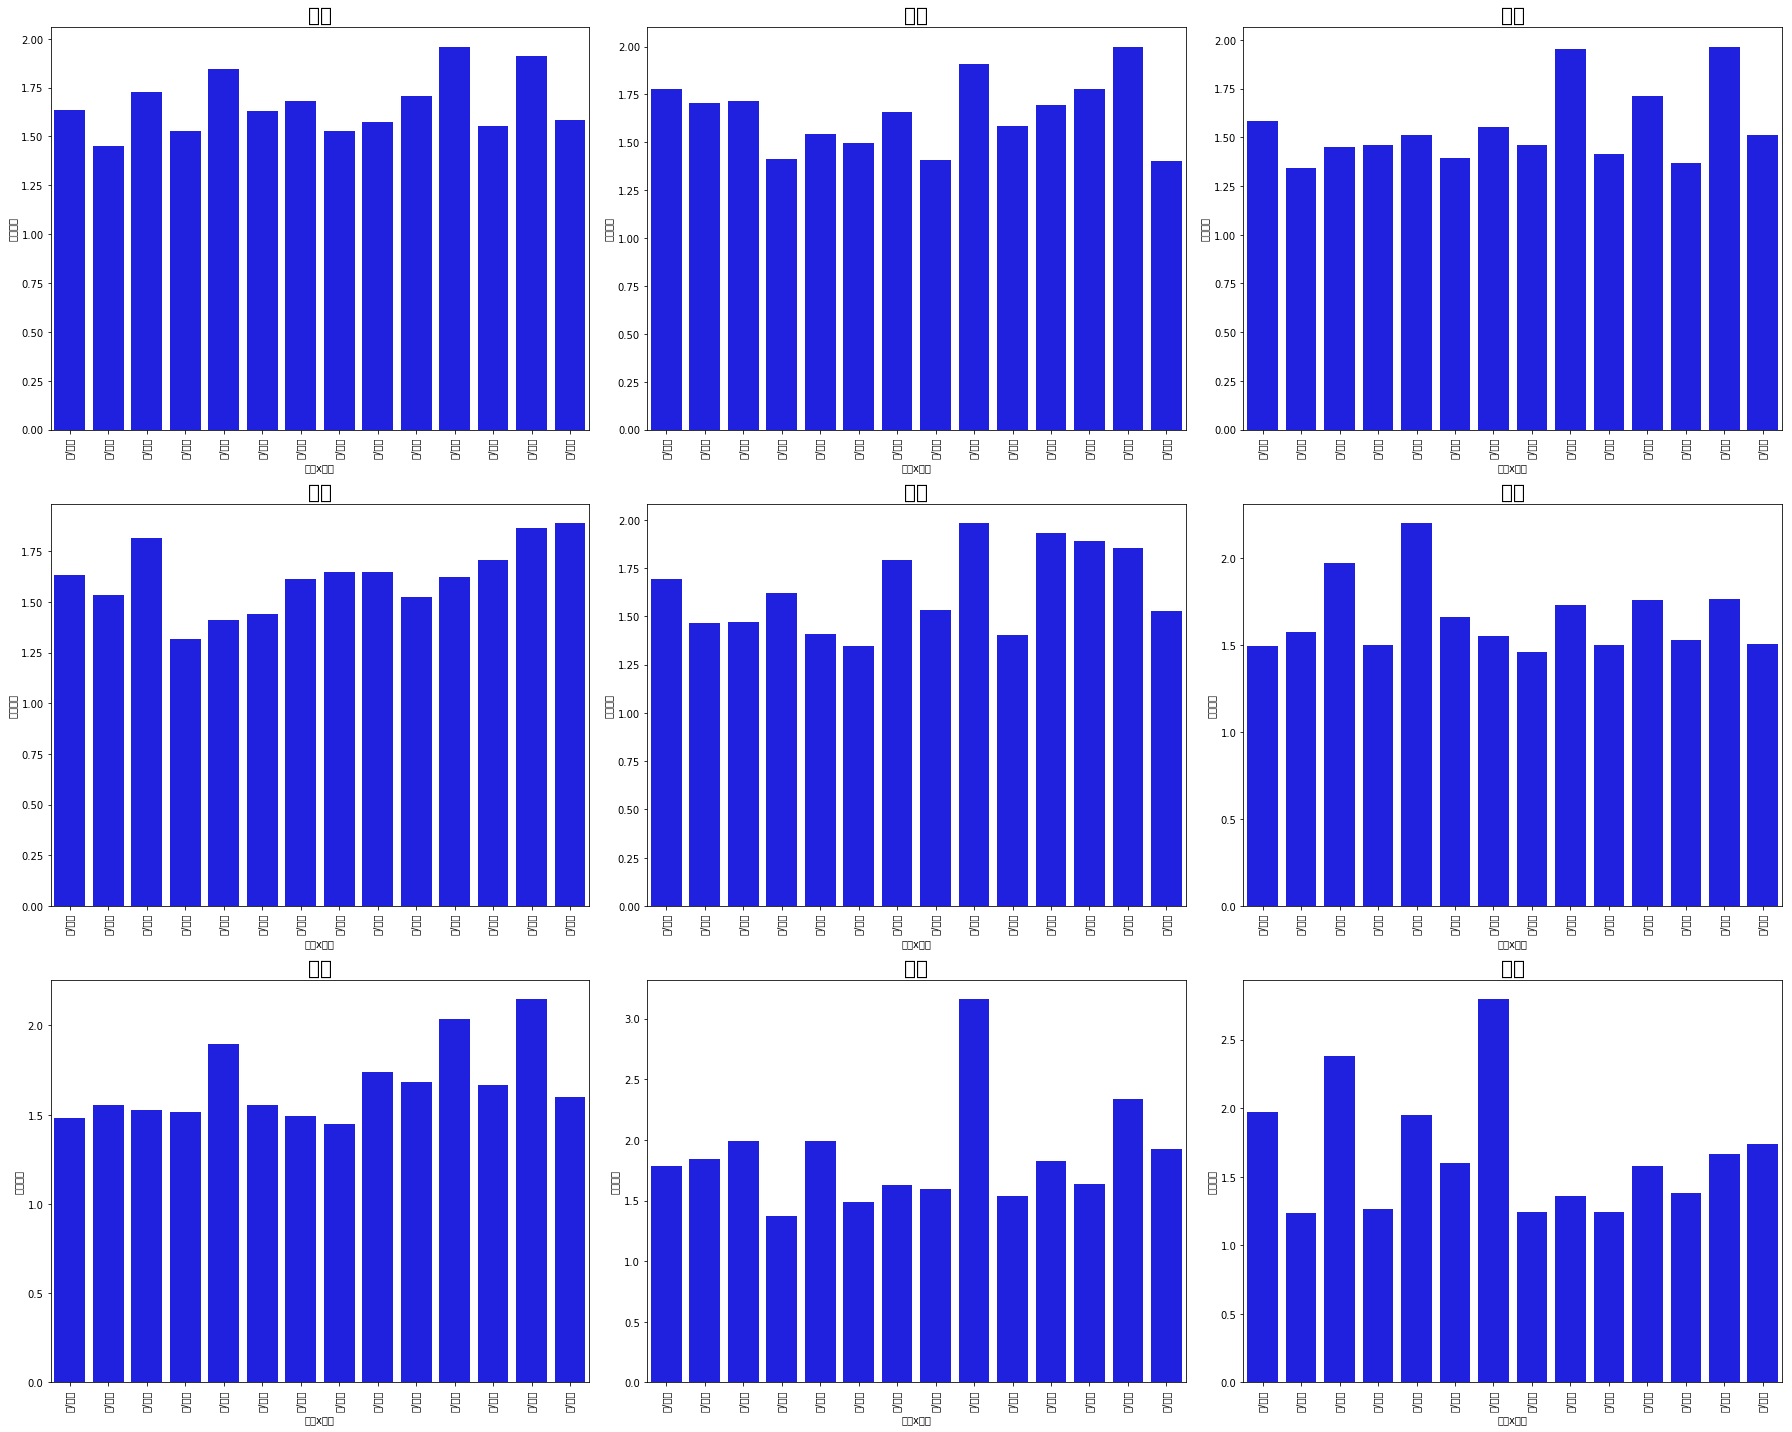

In [22]:
# 비주요 지역별 시도x요일x주야 평균 사상자수

b=  ['경기','경북','경남','전북','전남','충북','충남','강원','제주']


fig = plt.figure(figsize=(25,20))

for n,i in enumerate(b):
    temp = pd.DataFrame(df[df.발생지시도==i].groupby('요일x주야').mean().사상자수)
    temp = temp.loc[['월/주간','월/야간','화/주간','화/야간','수/주간','수/야간','목/주간','목/야간','금/주간','금/야간','토/주간','토/야간','일/주간','일/야간']]
    
    
    
    ax = fig.add_subplot(3,3,n+1)
    sns.barplot(x=temp.index, y=temp.사상자수,ax=ax, color='b')
    plt.xticks(rotation='vertical')
    plt.title(i,fontsize=20)
    
plt.tight_layout()


In [26]:
# k-l divergence 해보기

In [23]:
total = train_train.groupby(['발생지시도','요일','주야']).count().도로형태.sort_index()
#total

a = train_train.groupby(['발생지시도','요일','주야']).sum().사망자수.sort_index()
#a

b=train_train.groupby(['발생지시도','요일','주야']).sum().총부상자수.sort_index()
#b

temp = (a*12+b*3)/total

#temp

for i,j,k in temp.index:
    train_train.loc[(train_train.발생지시도==i)&(train_train.요일==j)&(train_train.주야==k),'발생지시도x요일x주야_위험도'] = temp[i,j,k]

train_train.발생지시도x요일x주야_위험도.describe()

count    15022.000000
mean        14.273865
std          1.048010
min         12.000000
25%         13.626168
50%         14.096234
75%         14.680000
max         21.420000
Name: 발생지시도x요일x주야_위험도, dtype: float64

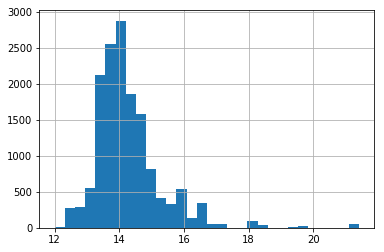

In [24]:
train_train.발생지시도x요일x주야_위험도.hist(bins=30)

대부분의 시도x요일x주야 조합의 위험도는 15안쪽이고, 높은 지역은 21까지도 나타남.                                                     
개인적으로는 16을 기준으로 16이상인 시도x요일x주야 조합은 위험도가 높은 조합이고, 미만인 조합은 위험도가 낮은 조합으로 볼 수 있지 않을까 생각. 

In [25]:
train_train[train_train.발생지시도x요일x주야_위험도>=16].groupby(['발생지시도','요일','주야']).mean().발생지시도x요일x주야_위험도.sort_values(ascending=False).head()

발생지시도  요일  주야
강원     금   주간    21.420000
제주     화   주간    19.650000
광주     목   주간    19.411765
제주     목   주간    18.545455
울산     일   주간    18.400000
Name: 발생지시도x요일x주야_위험도, dtype: float64

몇몇 위험도가 높은 시도x요일x주야 조합을 보면, 보통 평일 주간일 때 위험도가 높아 보임

In [26]:
# train data에서 구한 시도x요일x주야별 위험도를 test data에 적용

temp = train_train.groupby(['발생지시도','요일','주야']).mean().발생지시도x요일x주야_위험도
for i, j, k in temp.index:
    train_test.loc[(train_test.발생지시도==i)&(train_test.요일==j)&(train_test.주야==k),'발생지시도x요일x주야_위험도'] = temp[i,j,k]    

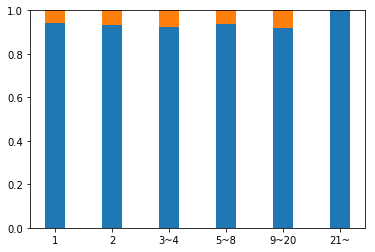

In [27]:
high=[]
low=[]

# 사상자수 1
total = train_test[(train_test.사상자수==1)].shape[0]
a = train_test[(train_test.사상자수==1)&(train_test.발생지시도x요일x주야_위험도<=16)].shape[0]
b = train_test[(train_test.사상자수==1)&(train_test.발생지시도x요일x주야_위험도>16)].shape[0]

low.append(a/total)
high.append(b/total)

# 사상자수 2
total = train_test[(train_test.사상자수==2)].shape[0]
a = train_test[(train_test.사상자수==2)&(train_test.발생지시도x요일x주야_위험도<=16)].shape[0]
b = train_test[(train_test.사상자수==2)&(train_test.발생지시도x요일x주야_위험도>16)].shape[0]

low.append(a/total)
high.append(b/total)

# 사상자수 3~4
total = train_test[(train_test.사상자수>=3)&(train_test.사상자수<=4)].shape[0]
a = train_test[(train_test.사상자수>=3)&(train_test.사상자수<=4)&(train_test.발생지시도x요일x주야_위험도<=16)].shape[0]
b = train_test[(train_test.사상자수>=3)&(train_test.사상자수<=4)&(train_test.발생지시도x요일x주야_위험도>16)].shape[0]

low.append(a/total)
high.append(b/total)

# 사상자수 5~8
total = train_test[(train_test.사상자수>=5)&(train_test.사상자수<=8)].shape[0]
a = train_test[(train_test.사상자수>=5)&(train_test.사상자수<=8)&(train_test.발생지시도x요일x주야_위험도<=16)].shape[0]
b = train_test[(train_test.사상자수>=5)&(train_test.사상자수<=8)&(train_test.발생지시도x요일x주야_위험도>16)].shape[0]

low.append(a/total)
high.append(b/total)

# 사상자수 9~20
total = train_test[(train_test.사상자수>=9)&(train_test.사상자수<=20)].shape[0]
a = train_test[(train_test.사상자수>=9)&(train_test.사상자수<=20)&(train_test.발생지시도x요일x주야_위험도<=16)].shape[0]
b = train_test[(train_test.사상자수>=9)&(train_test.사상자수<=20)&(train_test.발생지시도x요일x주야_위험도>16)].shape[0]

low.append(a/total)
high.append(b/total)

# 사상자수 20~
total = train_test[(train_test.사상자수>=21)].shape[0]
a = train_test[(train_test.사상자수>=21)&(train_test.발생지시도x요일x주야_위험도<=16)].shape[0]
b = train_test[(train_test.사상자수>=21)&(train_test.발생지시도x요일x주야_위험도>16)].shape[0]

low.append(a/total)
high.append(b/total)

N = 6 
ind = np.arange(N)
width = 0.35

p1 = plt.bar(ind, low, width)
p2 = plt.bar(ind, high, width, bottom=low)

#plt.ylabel('주야 비율')
plt.xticks(ind, ('1','2','3~4','5~8','9~20','21~'))
#plt.legend((p1[0],p2[0]),('주간','야간'))
plt.show()

발생시군구_위험도와 마찬가지로, 사상자수가 많아지더라도 위험도 수치가 높다고 나타난 변수 비율에 큰 차이가 없어서 단순히 이 변수 하나만으로는 의미가 없다고 생각. 하지만 다른 위험도 변수들과 같이 위험도 합이나 가중평균에 같이 사용됐을 때 의미가 있을 수 도 있다고 생각.

## 3. 차량조합_위험도

사고가 났을 때, 특히 사고피해가 높은 차종 조합이 있을 것이라고 생각해서 차종조합별로 평균 사상자수를 확인해봄.    

In [28]:
df['차량조합'] = df['당사자종별_1당_대분류'] + '/' + df['당사자종별_2당_대분류']

In [29]:
temp = pd.DataFrame(df.groupby('차량조합').mean().사상자수.sort_values(ascending=False))

temp
# 이륜차 원동기장치자전거 자전거 사륜오토바이 보행자

# 승합차-원동기장치자전거 1.44
# 이륜차-승합차 1.42
# 승합차-이륜차 1.24
# 자전거-승합차 1.17
# 승합차-자전거 1.07
# 농기계-승합차 1.0
# 승합차-사륜오토바이 1
# 승합차-보행자 1.13


,사상자수
차량조합,
승합차/승합차,16.333333
건설기계/승합차,9.375000
승합차/건설기계,7.642857
승합차/화물차,6.144444
승합차/승용차,5.301370
화물차/승합차,4.958904
승용차/승합차,4.376623
승합차/없음,4.222892
승합차/특수차,3.750000


- 차종별 평균 사상자수를 보면, 승합차-특수차 조합의 사상자수는 3.75로 높은 반면 특수차-승합차 조합의 사상자수는 2.4로 좀 더 낮은 편이다. 즉 단순 차종조합보다는 어떤차가 가해자이고 어떤 차가 피해자인지에 따라서도 그 피해정도가 달라지는 것 같다.        
                               
- 특히 평균 사상자수가 높은 상위부분에는 거의 모두 승합차가 포함돼있다. 그만큼 승합차가 사고가 났을 때 그 피해 정도가 크다는 것을 보여준다. 
                          
- 이때 아무리 승합차더라도, 애초에 탑승인원이 적은 보행자, 이륜차, 자전거, 사륜오토바이, 원동기장치자전거와 사고가 나면 평균 사상자수가 적어지는 특징이 있다. (승합차-보행자: 1.13, 승합차-자전거:1.07, 승합차-이륜차:1.24, 승합차-원동기장치자전거:1.44, 이륜차-승합차:1.42, 자전거-승합차:1.17)

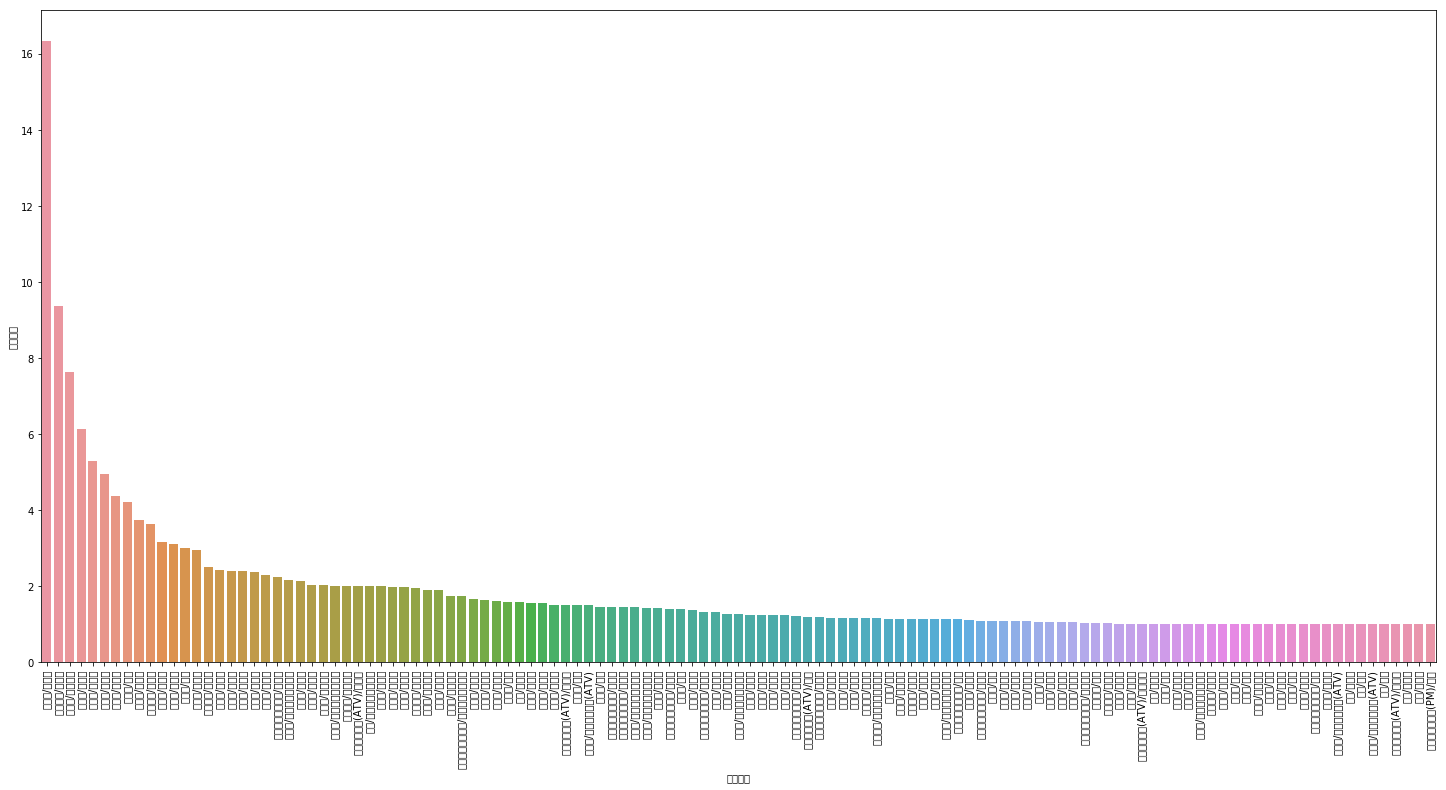

In [30]:
plt.figure(figsize=(25,12))
sns.barplot(x=temp.index, y=temp.사상자수)
plt.xticks(rotation='vertical');

대부분의 경우 차종 조합별로 평균 사상자수가 비슷비슷한 경우도 있지만, 일부 차종에서는 유난히 수치가 높게 나타남. 즉, 사고가 나면 위험한 특정 몇몇 차종 조합이 있다고 생각. 평균 사상자수가 높게 나타나는 상위항목들은 거의 다 승합차가 포함돼있음. 

In [31]:
print(df[df.차량조합=='건설기계/승합차'].groupby('사고유형_중분류').mean().사상자수.sort_index(ascending=False))
print('----------------------')
print(df[df.차량조합=='건설기계/승합차'].groupby('사고유형_중분류').count().사상자수.sort_index(ascending=False))

사고유형_중분류
측면충돌       1.000000
측면직각충돌    10.333333
추돌        12.000000
Name: 사상자수, dtype: float64
----------------------
사고유형_중분류
측면충돌      1
측면직각충돌    6
추돌        1
Name: 사상자수, dtype: int64


이때 똑같은 차종 조합끼리의 사고라도 어떤 사고유형인지에 따라 피해정도가 다를 것이라고 생각해서 좀 더 세분화 하려고 했지만, 세분화 하면 위와같이 각 경우별로 데이터 수가 너무 적어서 더 세분화 하진 않고 차종조합별로 위험도를 계산하기로 함.

In [32]:
total = train_train.groupby(['당사자종별_1당_대분류','당사자종별_2당_대분류']).count().사고유형_중분류
#total

a = train_train.groupby(['당사자종별_1당_대분류','당사자종별_2당_대분류']).sum().사망자수.sort_index()
#a

b = train_train.groupby(['당사자종별_1당_대분류','당사자종별_2당_대분류']).sum().총부상자수.sort_index()
#b

temp = (a*12+b*3)/total

temp

for i,j in temp.index:
    train_train.loc[(train_train.당사자종별_1당_대분류==i)&(train_train.당사자종별_2당_대분류==j),'차량조합_위험도'] = temp[i,j]

train_train.차량조합_위험도.describe()

count    15022.000000
mean        14.273865
std          3.866146
min         12.000000
25%         12.451557
50%         12.548387
75%         14.298335
max         69.782609
Name: 차량조합_위험도, dtype: float64

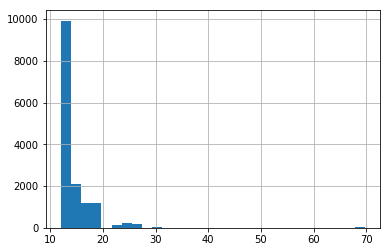

In [33]:
train_train.차량조합_위험도.hist(bins=30)

대부분의 차량조합의 위험도는 15안쪽이고, 높은 조합은 69까지도 나타남.       
개인적으로는 16을 기준으로 16이상인 차량조합은 위험도가 높은 조합이고, 미만인 조합은 위험도가 낮은 조합으로 볼 수 있지 않을까 생각. 

In [34]:
train_train[train_train.차량조합_위험도>=20].groupby(['당사자종별_1당_대분류','당사자종별_2당_대분류']).mean().차량조합_위험도.sort_values(ascending=False)

당사자종별_1당_대분류  당사자종별_2당_대분류
승합차           승합차             69.782609
건설기계          승합차             64.000000
승합차           건설기계            46.800000
              화물차             31.187500
              승용차             27.230769
승용차           열차              27.000000
화물차           승합차             25.836735
승용차           승합차             24.327869
특수차           특수차             24.000000
건설기계          승용차             24.000000
특수차           승용차             22.666667
승합차           없음              22.077670
원동기장치자전거      이륜차             21.000000
건설기계          특수차             21.000000
Name: 차량조합_위험도, dtype: float64

특히 위험도가 높은 차종조합 몇몇을 확인해보면, 승합차-승합차가 위험도 69로 압도적으로 가장 위험도가 높았고, 그 밑으로도 건설기계-승합차, 승합차-건설기계, 승합차-화물차, 승합차-승용차의 사고위험도가 높게 나오는 걸 보면, 승합차가 특히 사고났을 때 피해자 수가 높게 나타나는 경향이 있는 것 같다

In [35]:
# train data에서 구한 차량조합별 위험도를 test data에 적용


temp = train_train.groupby(['당사자종별_1당_대분류','당사자종별_2당_대분류']).mean().차량조합_위험도
for i, j in temp.index:
    train_test.loc[(train_test.당사자종별_1당_대분류==i)&(train_test.당사자종별_2당_대분류==j),'차량조합_위험도'] = temp[i,j]    

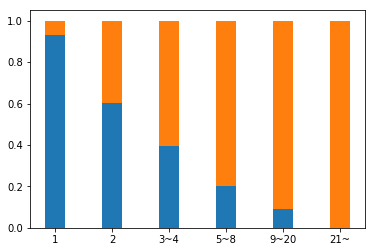

In [36]:
high=[]
low=[]

# 사상자수 1
total = train_test[(train_test.사상자수==1)].shape[0]
a = train_test[(train_test.사상자수==1)&(train_test.차량조합_위험도<=16)].shape[0]
b = train_test[(train_test.사상자수==1)&(train_test.차량조합_위험도>16)].shape[0]

low.append(a/total)
high.append(b/total)

# 사상자수 2
total = train_test[(train_test.사상자수==2)].shape[0]
a = train_test[(train_test.사상자수==2)&(train_test.차량조합_위험도<=16)].shape[0]
b = train_test[(train_test.사상자수==2)&(train_test.차량조합_위험도>16)].shape[0]

low.append(a/total)
high.append(b/total)

# 사상자수 3~4
total = train_test[(train_test.사상자수>=3)&(train_test.사상자수<=4)].shape[0]
a = train_test[(train_test.사상자수>=3)&(train_test.사상자수<=4)&(train_test.차량조합_위험도<=16)].shape[0]
b = train_test[(train_test.사상자수>=3)&(train_test.사상자수<=4)&(train_test.차량조합_위험도>16)].shape[0]

low.append(a/total)
high.append(b/total)

# 사상자수 5~8
total = train_test[(train_test.사상자수>=5)&(train_test.사상자수<=8)].shape[0]
a = train_test[(train_test.사상자수>=5)&(train_test.사상자수<=8)&(train_test.차량조합_위험도<=16)].shape[0]
b = train_test[(train_test.사상자수>=5)&(train_test.사상자수<=8)&(train_test.차량조합_위험도>16)].shape[0]

low.append(a/total)
high.append(b/total)

# 사상자수 9~20
total = train_test[(train_test.사상자수>=9)&(train_test.사상자수<=20)].shape[0]
a = train_test[(train_test.사상자수>=9)&(train_test.사상자수<=20)&(train_test.차량조합_위험도<=16)].shape[0]
b = train_test[(train_test.사상자수>=9)&(train_test.사상자수<=20)&(train_test.차량조합_위험도>16)].shape[0]

low.append(a/total)
high.append(b/total)

# 사상자수 20~
total = train_test[(train_test.사상자수>=21)].shape[0]
a = train_test[(train_test.사상자수>=21)&(train_test.차량조합_위험도<=16)].shape[0]
b = train_test[(train_test.사상자수>=21)&(train_test.차량조합_위험도>16)].shape[0]

low.append(a/total)
high.append(b/total)

N = 6 
ind = np.arange(N)
width = 0.35

p1 = plt.bar(ind, low, width)
p2 = plt.bar(ind, high, width, bottom=low)

#plt.ylabel('주야 비율')
plt.xticks(ind, ('1','2','3~4','5~8','9~20','21~'))
#plt.legend((p1[0],p2[0]),('주간','야간'))
plt.show()

앞의 두 위험도가 다르게, 차량조합은 사고의 피해 정도에 매우 많은 영향을 끼치는 것 같다. 보통 사상자수가 높은 사고일수록 차량조합 위험도가 높게 나타나는 사고들의 비율이 매우 높게 나타나는 것을 확인해볼 수 있다. 사상자수가 5명 이상인 사고들은 애초에 많이 일어나지는 않지만, 그래도 일어난다면 차종조합의 위험도가 높을 확률이 높아보인다.

## 3. 사고유형중분류_위험도

사고유형 대분류별로 위험도를 계산할지, 좀 더 세분화된 중분류별로 위험도를 계산할지를 생각해보기위해 사고유형별로 평균 사상자수를 살펴봄

In [37]:
df.groupby('사고유형_중분류').mean().사상자수.sort_values(ascending=False)

사고유형_중분류
직전진행          3.000000
정면충돌          2.640025
추돌            2.488006
차단기돌파         2.000000
측면직각충돌        1.983866
측면충돌          1.795302
주/정차차량 충돌     1.600000
공작물충돌         1.520690
기타            1.487429
전도            1.424528
전도전복          1.417363
도로이탈          1.416048
전복            1.333333
보도통행중         1.295620
후진중충돌         1.200000
길가장자리구역통행중    1.178344
횡단중           1.091098
차도통행중         1.076835
경보기무시         1.000000
Name: 사상자수, dtype: float64

사고유형 대분류가 차대 사람인 사고들의 사고유형 중분류는 횡단중, 차도통행중, 보도통행중, 길가장자리구역통행중인데, 이런 사고유형 중분류들의 평균 사상자수는 보통 낮은 수치를 보여서 차대사람 사고의 피해 규모는 그리 크지 않아보인다.

반면 사고유형 대분류가 차대차인 사고들의 사고유형 중분류들은 평균 사상자수의 편차가 큰 것 같다. 후진중 충돌은 평균 사상자수가 1.2명으로 낮은 편이고, 정면충돌은 2.64로 매우 높은 편이다. 즉 차대차 사고의 경우 피해의 심각성 정도가 사고유형 중분류별로 편차가 크기 때문에, 사고유형 대분류보다는 더 세세하게 중분류별로 위험도를 파악해야 할 것 같다.

In [38]:
total = train_train.groupby(['사고유형_중분류']).count().당사자종별_1당_대분류
#total

a = train_train.groupby(['사고유형_중분류']).sum().사망자수.sort_index()
#a

b = train_train.groupby(['사고유형_중분류']).sum().총부상자수.sort_index()
#b

temp = (a*12+b*3)/total

temp

for i in temp.index:
    train_train.loc[(train_train.사고유형_중분류==i),'사고유형_위험도'] = temp[i]

train_train.사고유형_위험도.describe()

count    15022.000000
mean        14.273865
std          1.795045
min         12.000000
25%         12.340360
50%         13.770619
75%         15.392697
max         27.000000
Name: 사고유형_위험도, dtype: float64

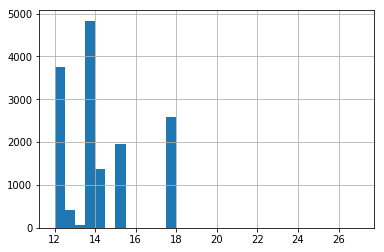

In [39]:
train_train.사고유형_위험도.hist(bins=30)

대부분의 사고유형 중분류의 위험도는 16안쪽이고, 높은 사고유형은 27까지도 나타남.       
개인적으로는 16이상인 차량조합은 위험도가 높은 조합이고, 미만인 조합은 위험도가 낮은 조합으로 볼 수 있지 않을까 생각. 

In [40]:
train_train[train_train.사고유형_위험도>=16].groupby(['사고유형_중분류']).mean().사고유형_위험도.sort_values(ascending=False)

사고유형_중분류
직전진행     27.000000
차단기돌파    19.500000
정면충돌     17.849693
추돌       17.502783
Name: 사고유형_위험도, dtype: float64

특히 위험도가 높은 사고유형을 보면, 직전진행이 27로 가장 높고, 그다음이 차단기돌파, 정면충돌, 추돌사고가 위험도가 높게 나타난다.

In [41]:
# train data에서 구한 사고유형별 위험도를 test data에 적용

temp = train_train.groupby(['사고유형_중분류']).mean().사고유형_위험도
for i in temp.index:
    train_test.loc[(train_test.사고유형_중분류==i),'사고유형_위험도'] = temp[i]    
train_test.사고유형_위험도.describe()

count    10015.000000
mean        14.265647
std          1.764440
min         12.000000
25%         12.832258
50%         13.770619
75%         15.392697
max         17.849693
Name: 사고유형_위험도, dtype: float64

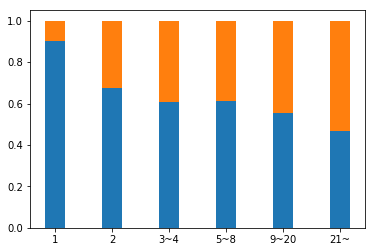

In [43]:
high=[]
low=[]

# 사상자수 1
total = train_test[(train_test.사상자수==1)].shape[0]
a = train_test[(train_test.사상자수==1)&(train_test.사고유형_위험도<=16)].shape[0]
b = train_test[(train_test.사상자수==1)&(train_test.사고유형_위험도>16)].shape[0]

low.append(a/total)
high.append(b/total)

# 사상자수 2
total = train_test[(train_test.사상자수==2)].shape[0]
a = train_test[(train_test.사상자수==2)&(train_test.사고유형_위험도<=16)].shape[0]
b = train_test[(train_test.사상자수==2)&(train_test.사고유형_위험도>16)].shape[0]

low.append(a/total)
high.append(b/total)

# 사상자수 3~4
total = train_test[(train_test.사상자수>=3)&(train_test.사상자수<=4)].shape[0]
a = train_test[(train_test.사상자수>=3)&(train_test.사상자수<=4)&(train_test.사고유형_위험도<=16)].shape[0]
b = train_test[(train_test.사상자수>=3)&(train_test.사상자수<=4)&(train_test.사고유형_위험도>16)].shape[0]

low.append(a/total)
high.append(b/total)

# 사상자수 5~8
total = train_test[(train_test.사상자수>=5)&(train_test.사상자수<=8)].shape[0]
a = train_test[(train_test.사상자수>=5)&(train_test.사상자수<=8)&(train_test.사고유형_위험도<=16)].shape[0]
b = train_test[(train_test.사상자수>=5)&(train_test.사상자수<=8)&(train_test.사고유형_위험도>16)].shape[0]

low.append(a/total)
high.append(b/total)

# 사상자수 9~20
total = train_test[(train_test.사상자수>=9)&(train_test.사상자수<=20)].shape[0]
a = train_test[(train_test.사상자수>=9)&(train_test.사상자수<=20)&(train_test.사고유형_위험도<=16)].shape[0]
b = train_test[(train_test.사상자수>=9)&(train_test.사상자수<=20)&(train_test.사고유형_위험도>16)].shape[0]

low.append(a/total)
high.append(b/total)

# 사상자수 20~
total = train_test[(train_test.사상자수>=21)].shape[0]
a = train_test[(train_test.사상자수>=21)&(train_test.사고유형_위험도<=16)].shape[0]
b = train_test[(train_test.사상자수>=21)&(train_test.사고유형_위험도>16)].shape[0]

low.append(a/total)
high.append(b/total)

N = 6 
ind = np.arange(N)
width = 0.35

p1 = plt.bar(ind, low, width)
p2 = plt.bar(ind, high, width, bottom=low)

#plt.ylabel('주야 비율')
plt.xticks(ind, ('1','2','3~4','5~8','9~20','21~'))
#plt.legend((p1[0],p2[0]),('주간','야간'))
plt.show()

사고유형_중분류도 사고의 피해 정도에 많은 영향을 끼치는 것 같다. 보통 사상자수가 높은 사고일수록 사고유형 위험도가 높게 나타나는 사고들의 비율이 어느정도 높게 나타나는 것을 확인해볼 수 있다.

## 4가지 위험도 활용

위의 4가지 위험도를 합, 단순평균, 가중평균 내서 비교해본 후, 어떻게 사용할 지를 고민해봄.             
                     
가중평균같은 경우, 사고피해정도에 영향력이 적어보였던 처음 두 발생시군구_위험도와 발생지시도x요일x주야 위험도는 가중치1, 어느정도 영향력이 있어보였던 사고유형_위험도는 가중치2, 영향력이 많아보였던 차종조합_위험도는 가중치 3을 주기로 함.

In [44]:
train_test['위험도합']=train_test.발생시군구_위험도 + train_test.발생지시도x요일x주야_위험도 + train_test.차량조합_위험도 + train_test.사고유형_위험도
train_test['위험도평균']=train_test.위험도합 / 4
train_test['위험도가중평균']= (train_test.발생시군구_위험도 + train_test.발생지시도x요일x주야_위험도 + train_test.차량조합_위험도*3 + train_test.사고유형_위험도*2)/4

train_test[['위험도합','위험도평균','위험도가중평균']].head()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

,위험도합,위험도평균,위험도가중평균
22192,53.819662,13.454915,22.734202
20239,52.982943,13.245736,22.556604
20989,58.036769,14.509192,25.172380
18177,54.773560,13.693390,23.004258
14464,54.200541,13.550135,22.805576


In [45]:
print(train_test.위험도합.describe())
print('---------------------------')
print(train_test.위험도평균.describe())
print('---------------------------')
print(train_test.위험도가중평균.describe())


count    10006.000000
mean        57.077518
std          5.408939
min         49.690955
25%         53.718797
50%         55.624031
75%         58.970989
max        117.443093
Name: 위험도합, dtype: float64
---------------------------
count    10006.000000
mean        14.269379
std          1.352235
min         12.422739
25%         13.429699
50%         13.906008
75%         14.742747
max         29.360773
Name: 위험도평균, dtype: float64
---------------------------
count    10006.000000
mean        24.969630
std          3.585378
min         21.688068
25%         22.878711
50%         23.876750
75%         25.530000
max         68.714501
Name: 위험도가중평균, dtype: float64


- 위험도합: 60 이상부터 위험한 사고라고 생각.
- 위험도평균: 16 이상부터 위험한 사고라고 생각.
- 위험도가중평균: 27 이상부터 위험한 사고라고 생각.

In [46]:
high_1=[]
low_1=[]

# 사상자수 1
total = train_test[(train_test.사상자수==1)].shape[0]
a = train_test[(train_test.사상자수==1)&(train_test.위험도합<=60)].shape[0]
b = train_test[(train_test.사상자수==1)&(train_test.위험도합>60)].shape[0]

low_1.append(a/total)
high_1.append(b/total)

# 사상자수 2
total = train_test[(train_test.사상자수==2)].shape[0]
a = train_test[(train_test.사상자수==2)&(train_test.위험도합<=60)].shape[0]
b = train_test[(train_test.사상자수==2)&(train_test.위험도합>60)].shape[0]

low_1.append(a/total)
high_1.append(b/total)

# 사상자수 3~4
total = train_test[(train_test.사상자수>=3)&(train_test.사상자수<=4)].shape[0]
a = train_test[(train_test.사상자수>=3)&(train_test.사상자수<=4)&(train_test.위험도합<=60)].shape[0]
b = train_test[(train_test.사상자수>=3)&(train_test.사상자수<=4)&(train_test.위험도합>60)].shape[0]

low_1.append(a/total)
high_1.append(b/total)

# 사상자수 5~8
total = train_test[(train_test.사상자수>=5)&(train_test.사상자수<=8)].shape[0]
a = train_test[(train_test.사상자수>=5)&(train_test.사상자수<=8)&(train_test.위험도합<=60)].shape[0]
b = train_test[(train_test.사상자수>=5)&(train_test.사상자수<=8)&(train_test.위험도합>60)].shape[0]

low_1.append(a/total)
high_1.append(b/total)

# 사상자수 9~20
total = train_test[(train_test.사상자수>=9)&(train_test.사상자수<=20)].shape[0]
a = train_test[(train_test.사상자수>=9)&(train_test.사상자수<=20)&(train_test.위험도합<=60)].shape[0]
b = train_test[(train_test.사상자수>=9)&(train_test.사상자수<=20)&(train_test.위험도합>60)].shape[0]

low_1.append(a/total)
high_1.append(b/total)

# 사상자수 20~
total = train_test[(train_test.사상자수>=21)].shape[0]
a = train_test[(train_test.사상자수>=21)&(train_test.위험도합<=60)].shape[0]
b = train_test[(train_test.사상자수>=21)&(train_test.위험도합>60)].shape[0]

low_1.append(a/total)
high_1.append(b/total)

In [47]:
high_2=[]
low_2=[]

# 사상자수 1
total = train_test[(train_test.사상자수==1)].shape[0]
a = train_test[(train_test.사상자수==1)&(train_test.위험도평균<=16)].shape[0]
b = train_test[(train_test.사상자수==1)&(train_test.위험도평균>16)].shape[0]

low_2.append(a/total)
high_2.append(b/total)

# 사상자수 2
total = train_test[(train_test.사상자수==2)].shape[0]
a = train_test[(train_test.사상자수==2)&(train_test.위험도평균<=16)].shape[0]
b = train_test[(train_test.사상자수==2)&(train_test.위험도평균>16)].shape[0]

low_2.append(a/total)
high_2.append(b/total)

# 사상자수 3~4
total = train_test[(train_test.사상자수>=3)&(train_test.사상자수<=4)].shape[0]
a = train_test[(train_test.사상자수>=3)&(train_test.사상자수<=4)&(train_test.위험도평균<=16)].shape[0]
b = train_test[(train_test.사상자수>=3)&(train_test.사상자수<=4)&(train_test.위험도평균>16)].shape[0]

low_2.append(a/total)
high_2.append(b/total)

# 사상자수 5~8
total = train_test[(train_test.사상자수>=5)&(train_test.사상자수<=8)].shape[0]
a = train_test[(train_test.사상자수>=5)&(train_test.사상자수<=8)&(train_test.위험도평균<=16)].shape[0]
b = train_test[(train_test.사상자수>=5)&(train_test.사상자수<=8)&(train_test.위험도평균>16)].shape[0]

low_2.append(a/total)
high_2.append(b/total)

# 사상자수 9~20
total = train_test[(train_test.사상자수>=9)&(train_test.사상자수<=20)].shape[0]
a = train_test[(train_test.사상자수>=9)&(train_test.사상자수<=20)&(train_test.위험도평균<=16)].shape[0]
b = train_test[(train_test.사상자수>=9)&(train_test.사상자수<=20)&(train_test.위험도평균>16)].shape[0]

low_2.append(a/total)
high_2.append(b/total)

# 사상자수 20~
total = train_test[(train_test.사상자수>=21)].shape[0]
a = train_test[(train_test.사상자수>=21)&(train_test.위험도평균<=16)].shape[0]
b = train_test[(train_test.사상자수>=21)&(train_test.위험도평균>16)].shape[0]

low_2.append(a/total)
high_2.append(b/total)

In [48]:
high_3=[]
low_3=[]

# 사상자수 1
total = train_test[(train_test.사상자수==1)].shape[0]
a = train_test[(train_test.사상자수==1)&(train_test.위험도가중평균<=27)].shape[0]
b = train_test[(train_test.사상자수==1)&(train_test.위험도가중평균>27)].shape[0]

low_3.append(a/total)
high_3.append(b/total)

# 사상자수 2
total = train_test[(train_test.사상자수==2)].shape[0]
a = train_test[(train_test.사상자수==2)&(train_test.위험도가중평균<=27)].shape[0]
b = train_test[(train_test.사상자수==2)&(train_test.위험도가중평균>27)].shape[0]

low_3.append(a/total)
high_3.append(b/total)

# 사상자수 3~4
total = train_test[(train_test.사상자수>=3)&(train_test.사상자수<=4)].shape[0]
a = train_test[(train_test.사상자수>=3)&(train_test.사상자수<=4)&(train_test.위험도가중평균<=27)].shape[0]
b = train_test[(train_test.사상자수>=3)&(train_test.사상자수<=4)&(train_test.위험도가중평균>27)].shape[0]

low_3.append(a/total)
high_3.append(b/total)

# 사상자수 5~8
total = train_test[(train_test.사상자수>=5)&(train_test.사상자수<=8)].shape[0]
a = train_test[(train_test.사상자수>=5)&(train_test.사상자수<=8)&(train_test.위험도가중평균<=27)].shape[0]
b = train_test[(train_test.사상자수>=5)&(train_test.사상자수<=8)&(train_test.위험도가중평균>27)].shape[0]

low_3.append(a/total)
high_3.append(b/total)

# 사상자수 9~20
total = train_test[(train_test.사상자수>=9)&(train_test.사상자수<=20)].shape[0]
a = train_test[(train_test.사상자수>=9)&(train_test.사상자수<=20)&(train_test.위험도가중평균<=27)].shape[0]
b = train_test[(train_test.사상자수>=9)&(train_test.사상자수<=20)&(train_test.위험도가중평균>27)].shape[0]

low_3.append(a/total)
high_3.append(b/total)

# 사상자수 20~
total = train_test[(train_test.사상자수>=21)].shape[0]
a = train_test[(train_test.사상자수>=21)&(train_test.위험도가중평균<=27)].shape[0]
b = train_test[(train_test.사상자수>=21)&(train_test.위험도가중평균>27)].shape[0]

low_3.append(a/total)
high_3.append(b/total)

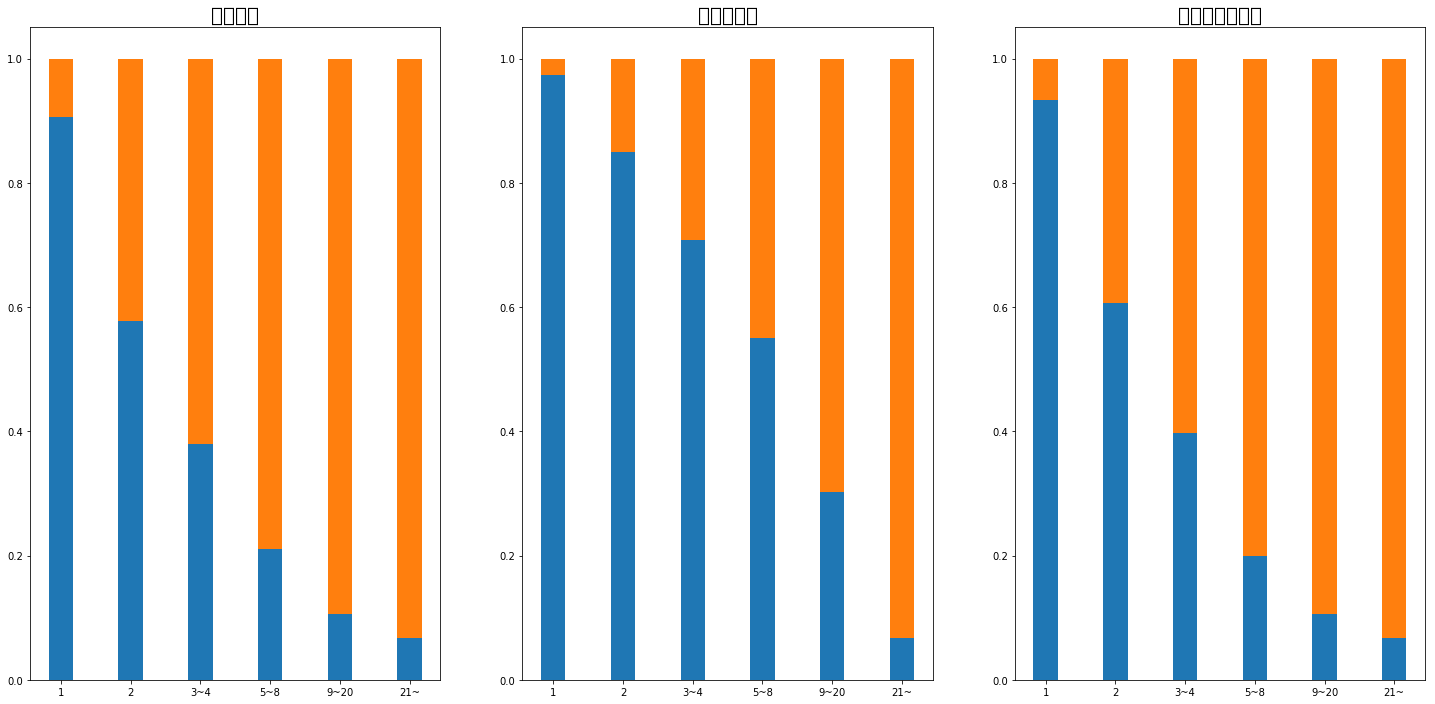

In [49]:
N = 6 
ind = np.arange(N)
width = 0.35

fig= plt.figure(figsize=(25,12))

ax=fig.add_subplot(1,3,1)
p1 = plt.bar(ind, low_1, width)
p2 = plt.bar(ind, high_1, width, bottom=low_1)
plt.xticks(ind, ('1','2','3~4','5~8','9~20','21~'))
plt.title('위험도합',fontsize=20)

ax=fig.add_subplot(1,3,2)
p1 = plt.bar(ind, low_2, width)
p2 = plt.bar(ind, high_2, width, bottom=low_2)
plt.xticks(ind, ('1','2','3~4','5~8','9~20','21~'))
plt.title('위험도평균',fontsize=20)

ax=fig.add_subplot(1,3,3)
p1 = plt.bar(ind, low_3, width)
p2 = plt.bar(ind, high_3, width, bottom=low_3)
plt.xticks(ind, ('1','2','3~4','5~8','9~20','21~'))
plt.title('위험도가중평균',fontsize=20)


plt.show()

위험도라는 변수를 이용해서 피해규모가 작은 사고와 피해규모가 큰 사고를 잘 구분해내는게 목적. 그런데 위험도합이나, 위험도 가중평균같은 경우는 피해규모가 그렇게 크지 않은 사상자수고 2명이나 3~4명인 사고들에서도 위험도가 높게 나타나는 비율이 조금 높게 나오는 것 같다. 

이와 달리 위험도평균은 사상자수가 3~4명인 사고들에서는 위험도 수치가 높게 나타나는 비율이 적고, 사상자수가 5~8명인 사고에서는 그 비율이 조금 늘어나긴 하지만 반을 넘어가진 않고, 사상자수가 9명 이상인 실제로 피해가 크다고 생각되는 사고들부터는 위험도 수치가 높게 나타나는 비율이 상당히 높아진다. 

이에 위험도 평균 변수가 사고피해정도가 작은 사고와 큰 사고를 더 잘 구분지어줄 수 있다고 생각해서, 최종적으로는 위험도 평균을 사용하고자 한다.

# 결론

발생지시군구_위험도, 발생지시도x요일x주야_위험도, 차량조합_위험도, 사고유형_위험도 4가지 변수를 만든 후, 이 4가지 변수를 단순 평균한 위험도평균 변수를 사용하기.

In [50]:
# 발생지시군구_위험도

total= df.groupby(['발생지시도','발생지시군구']).count().주야.sort_index()
a = df.groupby(['발생지시도','발생지시군구']).sum().사망자수.sort_index()
b = df.groupby(['발생지시도','발생지시군구']).sum().총부상자수.sort_index()
temp=(a*12+b*3)/total

for i,j in temp.index:
    df.loc[(df.발생지시도==i)&(df.발생지시군구==j),'발생지시군구_위험도'] = temp[i,j]

#df.발생지시군구_위험도.describe()

# 발생지시도x요일x주야_위험도

total = df.groupby(['발생지시도','요일','주야']).count().도로형태.sort_index()
a = df.groupby(['발생지시도','요일','주야']).sum().사망자수.sort_index()
b = df.groupby(['발생지시도','요일','주야']).sum().총부상자수.sort_index()
temp = (a*12+b*3)/total

for i,j,k in temp.index:
    df.loc[(df.발생지시도==i)&(df.요일==j)&(df.주야==k),'발생지시도x요일x주야_위험도'] = temp[i,j,k]

#df.발생지시도x요일x주야_위험도.describe()

# 차량조합_위험도

total = df.groupby(['당사자종별_1당_대분류','당사자종별_2당_대분류']).count().사고유형_중분류
a = df.groupby(['당사자종별_1당_대분류','당사자종별_2당_대분류']).sum().사망자수.sort_index()
b = df.groupby(['당사자종별_1당_대분류','당사자종별_2당_대분류']).sum().총부상자수.sort_index()
temp = (a*12+b*3)/total

for i,j in temp.index:
    df.loc[(df.당사자종별_1당_대분류==i)&(df.당사자종별_2당_대분류==j),'차량조합_위험도'] = temp[i,j]

#df.차량조합_위험도.describe()

# 사고유형_위험도

total = df.groupby(['사고유형_중분류']).count().당사자종별_1당_대분류
a = df.groupby(['사고유형_중분류']).sum().사망자수.sort_index()
b = df.groupby(['사고유형_중분류']).sum().총부상자수.sort_index()
temp = (a*12+b*3)/total

for i in temp.index:
    df.loc[(df.사고유형_중분류==i),'사고유형_위험도'] = temp[i]

#df.사고유형_위험도.describe()

In [51]:
# 위험도평균

df['위험도평균']=(df.발생지시군구_위험도+df.발생지시도x요일x주야_위험도+df.차량조합_위험도+df.사고유형_위험도)/ 4

df.위험도평균.describe()

count    25037.000000
mean        14.232656
std          1.234693
min         12.416826
25%         13.411554
50%         13.898207
75%         14.671503
max         30.473617
Name: 위험도평균, dtype: float64